# Introduction

https://www.kaggle.com/mlg-ulb/creditcardfraud

## Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Data
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

<h1> EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
filepath = "data/creditcard.csv"
df = pd.read_csv(filepath, engine="python")

In [3]:
df.shape

(284807, 31)

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


No handles with labels found to put in legend.


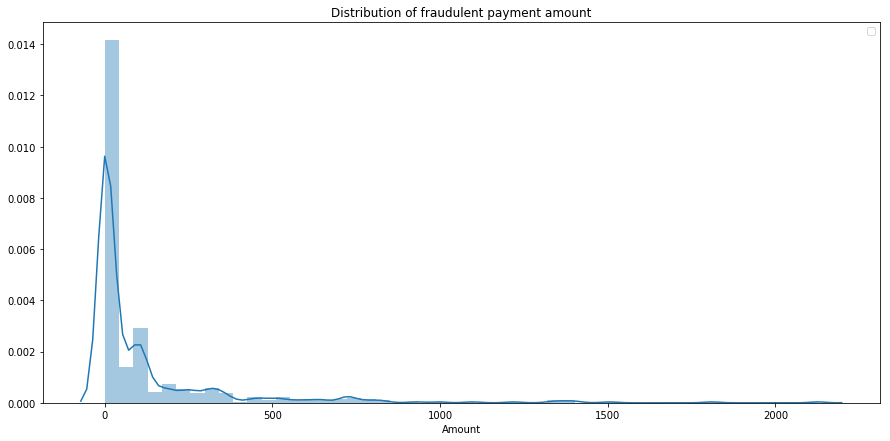

In [5]:
plt.figure(figsize=(15,7))
sns.distplot(df[df["Class"]==1]["Amount"])
plt.title("Distribution of fraudulent payment amount")
plt.legend()
plt.show()


<h1> Features preparation

We would like to get more out of the Time feature, to be able to analyze if the time has a influence on the fraudulent payment.

<h2> Time feature creation

In [6]:
def time_decompo(x):
    nb_min, nb_secs = x//60, x%60
    nb_hour, nb_mins = nb_min//60, nb_min%60
    nb_day, nb_hours = nb_hour//24, nb_hour%24
    return nb_day, nb_hours, nb_mins, nb_secs

In [7]:
df.apply(lambda x: [1, 2], axis=1)
df["Day"] = df["Time"].apply(lambda x: time_decompo(x)[0])
df["Hour"] = df["Time"].apply(lambda x: time_decompo(x)[1])
df["Min"] = df["Time"].apply(lambda x: time_decompo(x)[2])
df["Sec"] = df["Time"].apply(lambda x: time_decompo(x)[3])

<h2> Data viz with the new time features

No handles with labels found to put in legend.


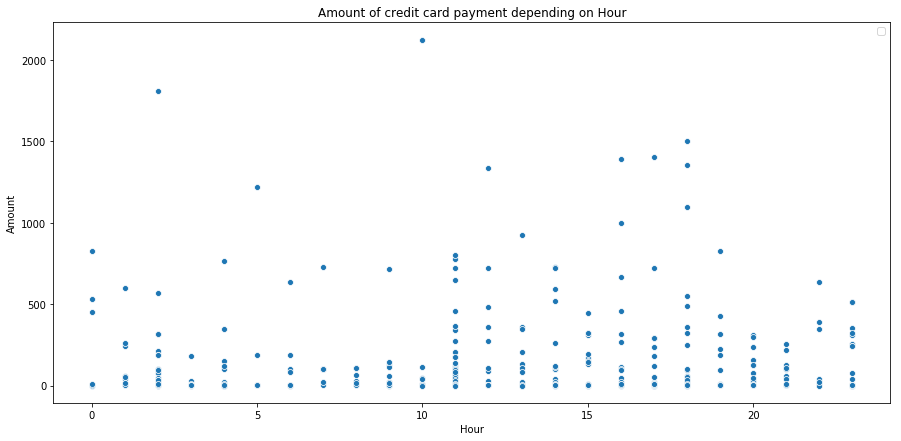

In [8]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=df[df["Class"]==1]["Hour"], y=df[df["Class"]==1]["Amount"])
plt.title("Amount of credit card payment depending on Hour")
plt.legend()
plt.show()

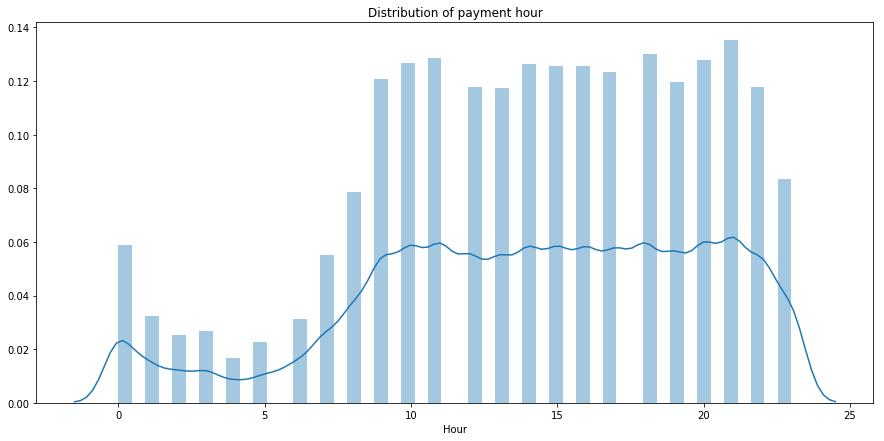

In [9]:
plt.figure(figsize=(15,7))
sns.distplot(df["Hour"])
plt.title("Distribution of payment hour")
plt.show()

Base on that distribution we can assess H=0 -> H=22H

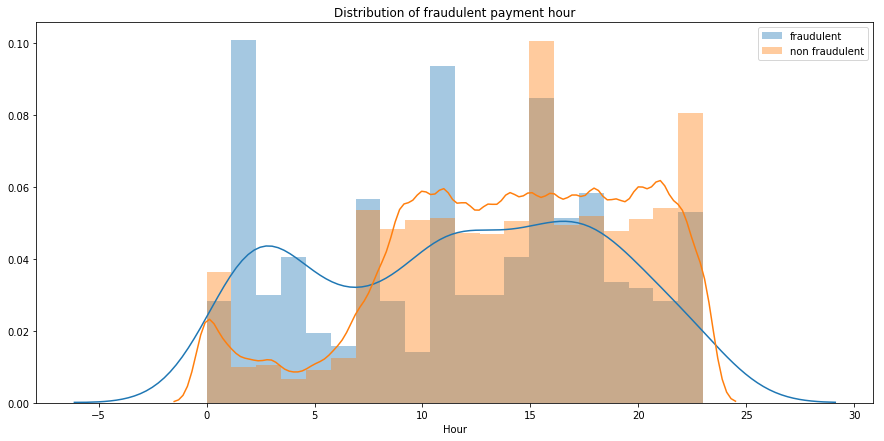

In [10]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(hspace=0.4)

sns.distplot(df[df["Class"]==1]["Hour"], label="fraudulent", bins=20)
sns.distplot(df[df["Class"]==0]["Hour"], label="non fraudulent", bins=20)
plt.title("Distribution of fraudulent payment hour")

plt.legend()
plt.show()

We can clearly noticed that there are more fraudulent payment during the night, It could be interresting to categorize by day and night the hour

In [11]:
def night_time(x):
    if x < 7 or x > 0:
        return 1
    else:
        return 0

In [12]:
df["NightTime"] = df["Hour"].apply(lambda x: night_time(x)) 

In [13]:
df.shape

(284807, 36)

<h2> Features selection

In [14]:
column_drop = ["Day", "Min", "Sec"]
df = df.drop(column_drop, axis=1)

<h2> Sampling

In [76]:
df_sample = df.sample(frac=0.1, replace=False, random_state=0)

In [77]:
df_sample.shape

(28481, 33)

In [78]:
ratio = df["Class"].sum()/df.shape[0]
print(f"Ratio of Class 1 in df: {round(ratio*100, 3)} %")
ratio = df_sample["Class"].sum()/df_sample.shape[0]
print(f"Ratio of Class 1 in df_sample: {round(ratio*100, 3)} %")

Ratio of Class 1 in df: 0.173 %
Ratio of Class 1 in df_sample: 0.193 %


<h2> Scalling of data

In [79]:
y = df_sample["Class"]
X = df_sample.drop("Class", axis=1)

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X=X)

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [81]:
X.shape

(28481, 32)

<h2> Split of X_train, X_test

In [82]:
X.shape

(28481, 32)

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [85]:
print(f"Ratio of Class 1 in y_train: {round((y_train.sum()/len(y_train))*100, 2)} %")
print(f"Ratio of Class 1 in y_test: {round((y_test.sum()/len(y_test))*100, 2)} %")

Ratio of Class 1 in y_train: 0.21 %
Ratio of Class 1 in y_test: 0.12 %


<h1> Imbalance data

<h2> Undersampling

In [86]:
from imblearn.under_sampling import RandomUnderSampler

In [87]:
rus = RandomUnderSampler(sampling_strategy='auto', return_indices=False, random_state=0, replacement=False, ratio=0.01)

In [88]:
X_undersamp, y_undersamp = rus.fit_resample(X_train, y_train)
X_undersamp.shape, y_undersamp.shape

((4848, 32), (4848,))

In [89]:
print(f"Ratio of Class 1 in y_undersamp: {round((y_undersamp.sum()/len(y_undersamp))*100, 2)} %")

Ratio of Class 1 in y_undersamp: 0.99 %


<h2> Oversampling (SMOTE)

In [90]:
from imblearn import over_sampling
smote = over_sampling.SMOTE(k_neighbors=5, ratio=0.01, random_state=0)

In [91]:
X_oversamp, y_oversamp = smote.fit_resample(X_train, y_train)
X_oversamp.shape, y_oversamp.shape

((22963, 32), (22963,))

In [92]:
print(f"Ratio of Class 1 in y_oversamp: {round((y_oversamp.sum()/len(y_oversamp))*100, 2)} %")

Ratio of Class 1 in y_oversamp: 0.99 %


<h1> Supervised Classification Model

In [93]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, f1_score, classification_report

<h2> Logistic Regression

In [94]:
from sklearn.linear_model import LogisticRegression

<h3> Raw data

In [95]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_score = lr.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9880743158423299

<h3> Undersampling

In [96]:
lr = LogisticRegression()
lr.fit(X_undersamp, y_undersamp)
y_score = lr.predict_proba(X_test)
fpr_u, tpr_u, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr_u, tpr_u)
roc_auc

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9833793622897313

<h3> Oversampling

In [97]:
lr = LogisticRegression()
lr.fit(X_oversamp, y_oversamp)
y_score = lr.predict_proba(X_test)
fpr_o, tpr_o, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr_o, tpr_o)
roc_auc

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9706251569168969

<h3> Comparison

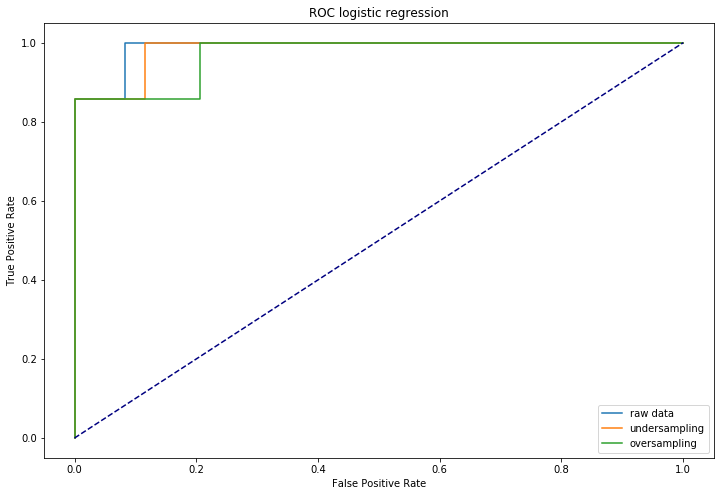

In [98]:
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr, label='raw data')
plt.plot(fpr_u, tpr_u, label='undersampling')
plt.plot(fpr_o, tpr_o, label='oversampling')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC logistic regression')
plt.legend(loc="lower right")
plt.show()

-> Best Model: LR with Undersampling

<h2> XG Boost

In [99]:
import xgboost as xgb

<h3> Raw data

In [100]:
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)
y_score = xg.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.9963344212904846

<h3> Undersampling

In [101]:
xg = xgb.XGBClassifier()
xg.fit(X_undersamp, y_undersamp)
y_score = xg.predict_proba(X_test)
fpr_u, tpr_u, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr_u, tpr_u)
roc_auc

0.9958322872206878

<h3> Oversampling

In [102]:
xg = xgb.XGBClassifier()
xg.fit(X_oversamp, y_oversamp)
y_score = xg.predict_proba(X_test)
fpr_o, tpr_o, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr_o, tpr_o)
roc_auc

0.9905598794878233

<h3> Comparison

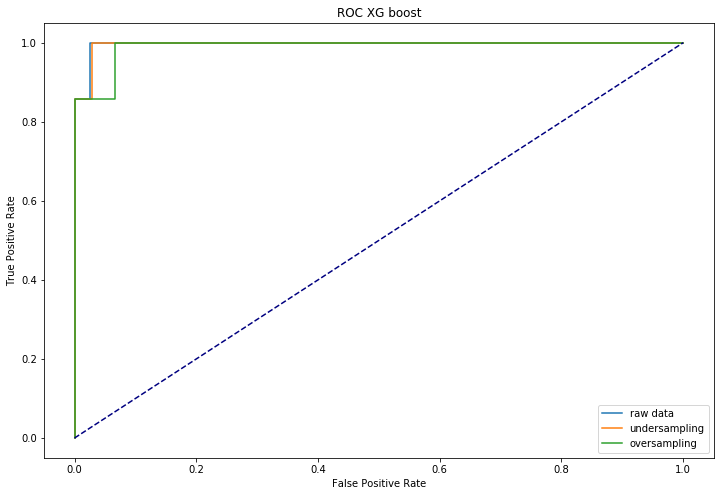

In [103]:
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr, label='raw data')
plt.plot(fpr_u, tpr_u, label='undersampling')
plt.plot(fpr_o, tpr_o, label='oversampling')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC XG boost')
plt.legend(loc="lower right")
plt.show()

-> Best Model: LR with Raw data

<h2> LGBM

In [104]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_oversamp, y_oversamp)
y_pred_lgbm = lgbm.predict_proba(X_test)[:,1]

In [105]:
print(classification_report(y_test, np.round(y_pred_lgbm)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5690
           1       0.75      0.86      0.80         7

   micro avg       1.00      1.00      1.00      5697
   macro avg       0.87      0.93      0.90      5697
weighted avg       1.00      1.00      1.00      5697



In [106]:
import lightgbm as lgb

<h3> Raw data

In [107]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
y_score = lgbm.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.7013055485814713

<h3> Undersampling

In [108]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_undersamp, y_undersamp)
y_score = lgbm.predict_proba(X_test)
fpr_u, tpr_u, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr_u, tpr_u)
roc_auc

0.9946773788601556

<h3> Oversampling

In [109]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_oversamp, y_oversamp)
y_score = lgbm.predict_proba(X_test)
fpr_o, tpr_o, _ = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr_o, tpr_o)
roc_auc

0.9942003514938489

<h3> Comparison

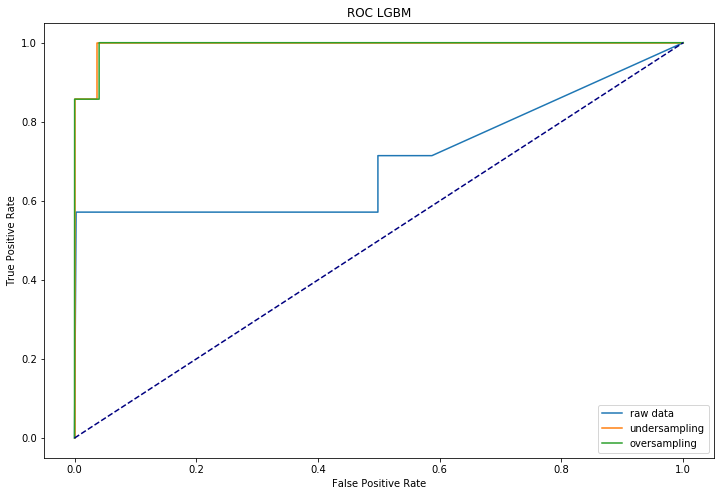

In [110]:
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr, label='raw data')
plt.plot(fpr_u, tpr_u, label='undersampling')
plt.plot(fpr_o, tpr_o, label='oversampling')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC LGBM')
plt.legend(loc="lower right")
plt.show()

-> Best Model: LR with Oversampling

<h1> Anomaly detection model (Unsupervised)

- Ratio of Class 1 in y: 0.17 %
- Ratio of Class 1 in y_undersamp: 0.99 %
- Ratio of Class 1 in y_oversamp: 0.99 %

In [144]:
X_train_inliers = X_train[y_train==0]
X_train_inliers.shape

(22736, 32)

In [115]:
X_test.shape

(5697, 32)

<h2> Gaussian distribution based

In [116]:
from sklearn.covariance import EllipticEnvelope

In [145]:
G = EllipticEnvelope(random_state=0)

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/sklearn/covariance/robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


In [ ]:
G.fit(X_train_inliers)
y_predG = G.predict(X_test)

In [ ]:
#y_predG = G.fit_predict(X_test)

In [146]:
# predict returns 1 for an inlier and -1 for an outlier
y_predG[y_predG == 1] = 0
y_predG[y_predG == -1] = 1

In [147]:
print(classification_report(y_test, y_predG))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      5690
           1       0.01      0.86      0.02         7

   micro avg       0.90      0.90      0.90      5697
   macro avg       0.51      0.88      0.49      5697
weighted avg       1.00      0.90      0.95      5697



<h2> Local Outlier Factor (LOF)

LOF takes a long time to compute.

In [120]:
from sklearn.neighbors import LocalOutlierFactor

In [152]:
LOF = LocalOutlierFactor(contamination="auto", novelty=True) 

In [153]:
LOF.fit(X_train_inliers)
y_predLOF = LOF.predict(X_test) #assign novelty to True

In [154]:
#y_predLOF = LOF.fit_predict(X_test) #assign novelty to False

In [155]:
y_predLOF[y_predLOF == 1] = 0
y_predLOF[y_predLOF == -1] = 1

In [156]:
n_errors = (y_predLOF != y_test).sum()
X_scores = LOF.negative_outlier_factor_
n_errors, LOF.offset_

(281, -1.5)

In [157]:
print(classification_report(y_test, y_predLOF))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      5690
           1       0.02      1.00      0.05         7

   micro avg       0.95      0.95      0.95      5697
   macro avg       0.51      0.98      0.51      5697
weighted avg       1.00      0.95      0.97      5697



<h2> Isolation Forest

In [158]:
from sklearn.ensemble import IsolationForest

In [160]:
IF = IsolationForest(n_estimators=100, contamination="auto", behaviour="new", random_state=0)
IF.fit(X_train_inliers)
y_predIF = IF.predict(X_test)

In [161]:
#y_predIF = IF.fit_predict(X_test)

In [162]:
y_predIF[y_predIF == 1] = 0
y_predIF[y_predIF == -1] = 1

In [163]:
print(classification_report(y_test, y_predIF))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      5690
           1       0.04      0.86      0.07         7

   micro avg       0.97      0.97      0.97      5697
   macro avg       0.52      0.92      0.53      5697
weighted avg       1.00      0.97      0.99      5697



<h2> Comparison

In [164]:
fpr_G, tpr_G, _ = roc_curve(y_test, -G.score_samples(X_test))
roc_auc = auc(fpr_G, tpr_G)
roc_auc

0.982852121516445

In [165]:
fpr_LOF, tpr_LOF, _ = roc_curve(y_test, -LOF.score_samples(X_test))
roc_auc = auc(fpr_LOF, tpr_LOF)
roc_auc

0.9966105950288727

In [166]:
fpr_IF, tpr_IF, _ = roc_curve(y_test, -IF.score_samples(X_test))
roc_auc = auc(fpr_IF, tpr_IF)
roc_auc

0.9950539794125033

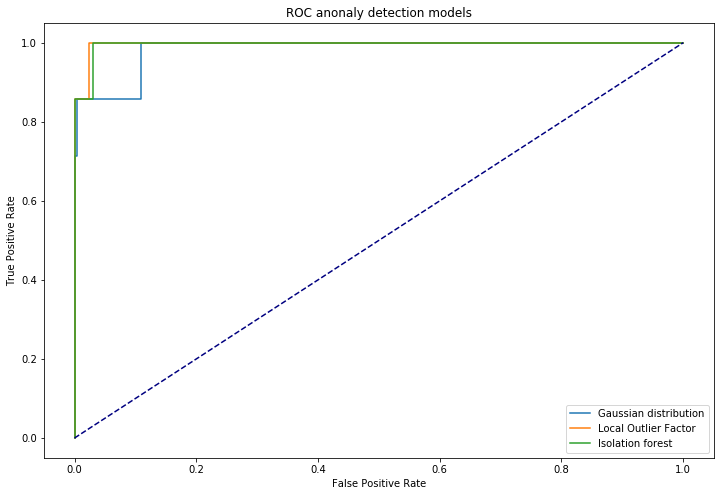

In [168]:
plt.figure(figsize=(12,8))

plt.plot(fpr_G, tpr_G, label='Gaussian distribution')
plt.plot(fpr_LOF, tpr_LOF, label='Local Outlier Factor')
plt.plot(fpr_IF, tpr_IF, label='Isolation forest')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC anonaly detection models')
plt.legend(loc="lower right")
plt.show()